# Assignment 1-1: K-Nearest Neighbors (k-NN)

In this notebook you will implement a K-Nearest Neighbors classifier on the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html).

Recall that the K-Nearest Neighbor classifier does the following:
- During training, the classifier simply memorizes the training data
- During testing, test images are compared to each training image; the predicted label is the majority vote among the K nearest training examples.

After implementing the K-Nearest Neighbor classifier, you will use *cross-validation* to find the best value of K.

The goals of this exercise are to go through a simple example of the data-driven image classification pipeline, and also to practice writing efficient, vectorized code in [PyTorch](https://pytorch.org/).

## Downloading the CIFAR-10 dataset 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import data_utils
import download

In [2]:
url = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
download_dir = "./data"
download.maybe_download_and_extract(url,download_dir)

Data has apparently already been downloaded and unpacked.


## Loading raw files and reading them as training and testing datasets

In [3]:
cifar10_dir = './data/cifar-10-batches-py'
X_train, y_train, X_test, y_test = data_utils.load_CIFAR10(cifar10_dir)

# Checking the size of the training and testing data
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


## Visualizing dataset samples
To give you a sense of the nature of the images in CIFAR-10, this cell visualizes some random examples from the training set.

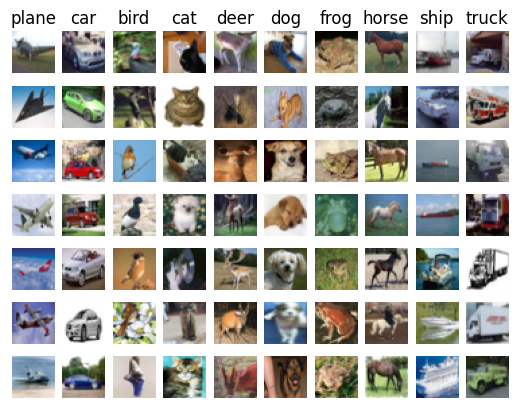

In [4]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

## Subsample the dataset
When implementing machine learning algorithms, it's usually a good idea to use a small sample of the full dataset. This way your code will run much faster, allowing for more interactive and efficient development. Once you are satisfied that you have correctly implemented the algorithm, you can then rerun with the entire dataset.

We will subsample the data to use only 500 training examples and 250 test examples:

In [5]:
# Memory error prevention by subsampling data

num_training = 500
mask = list(range(num_training))
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 250
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]

In [6]:
# reshaping data and placing into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(X_train.shape, X_test.shape)

(500, 3072) (250, 3072)


# K-Nearest Neighbors (k-NN)

Now that we have examined and prepared our data, it is time to implement the kNN classifier. We can break the process down into two steps:

1. Perform k-Nearest neighbours algorithm on the CiFAR-10 dataset to classify test images. 
2. Perform k-fold cross validation and plot the trend line with error bars that correspond to standard deviation to find the best value of the 'k' hyper parameter and best accuracy on the dataset.
3. Select the best value for k, and rerun the classifier on our full 5000 set of training examples.
4. Discussion: Discuss your understanding.

In [7]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

**Implementing and Initialising k-NN using Euclidean**

In [8]:
knn_sklearn = KNeighborsClassifier(n_neighbors=5, metric='euclidean')

Train the classifier

In [9]:
knn_sklearn.fit(X_train, y_train)

print("k-NN classifier has been trained.")

k-NN classifier has been trained.


Make predictions on the test set

In [10]:
y_pred_sklearn = knn_sklearn.predict(X_test)

Generating Confusion matrix

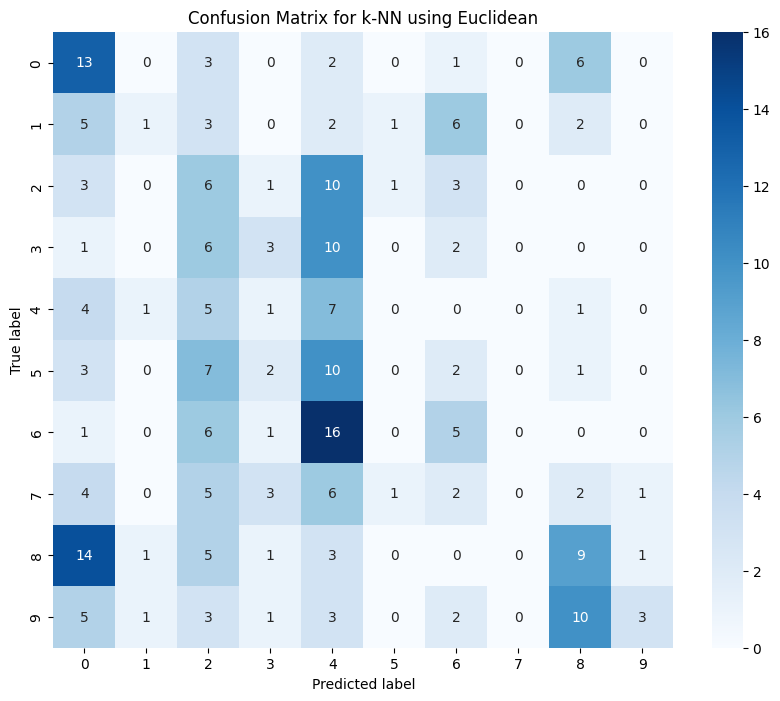

In [11]:
cm1 = confusion_matrix(y_test, y_pred_sklearn)
plt.figure(figsize=(10, 8))
sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for k-NN using Euclidean')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Calculating Accuracy

In [12]:
accuracy = accuracy_score(y_test, y_pred_sklearn)
print(f"Accuracy of k-NN classifier: {accuracy:.4f}")

Accuracy of k-NN classifier: 0.1880


Generate classification report

In [13]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
print("\
Classification Report:")
print(classification_report(y_test, y_pred_sklearn, target_names=class_names))
print(f"Accuracy with Euclidean distance: {accuracy:.4f}")

Classification Report:
              precision    recall  f1-score   support

    airplane       0.25      0.52      0.33        25
  automobile       0.25      0.05      0.08        20
        bird       0.12      0.25      0.16        24
         cat       0.23      0.14      0.17        22
        deer       0.10      0.37      0.16        19
         dog       0.00      0.00      0.00        25
        frog       0.22      0.17      0.19        29
       horse       0.00      0.00      0.00        24
        ship       0.29      0.26      0.28        34
       truck       0.60      0.11      0.18        28

    accuracy                           0.19       250
   macro avg       0.21      0.19      0.16       250
weighted avg       0.22      0.19      0.16       250

Accuracy with Euclidean distance: 0.1880


C:\Users\pc\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\pc\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\pc\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Initialize the k-NN classifier with k=5 and Manhattan distance**

In [14]:
knn_manhattan = KNeighborsClassifier(n_neighbors=5, metric='manhattan')

# Train the classifier
knn_manhattan.fit(X_train, y_train)

print("k-NN classifier using Manhattan distance has been trained.")

k-NN classifier using Manhattan distance has been trained.


Make predictions on the test set

In [15]:
y_pred_manhattan = knn_manhattan.predict(X_test)

Calculating accuracy

In [16]:
accuracy = accuracy_score(y_test, y_pred_manhattan)
print(f"Accuracy of k-NN classifier with Manhattan distance: {accuracy:.4f}")

Accuracy of k-NN classifier with Manhattan distance: 0.2040


Generating Classification report

In [17]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
print("\
Classification Report:")
print(classification_report(y_test, y_pred_manhattan, target_names=class_names))

Classification Report:
              precision    recall  f1-score   support

    airplane       0.26      0.56      0.35        25
  automobile       0.08      0.05      0.06        20
        bird       0.22      0.33      0.27        24
         cat       0.08      0.05      0.06        22
        deer       0.08      0.26      0.12        19
         dog       0.33      0.08      0.13        25
        frog       0.24      0.14      0.17        29
       horse       0.17      0.04      0.07        24
        ship       0.34      0.29      0.32        34
       truck       0.38      0.18      0.24        28

    accuracy                           0.20       250
   macro avg       0.22      0.20      0.18       250
weighted avg       0.23      0.20      0.19       250



Generate confusion matrix

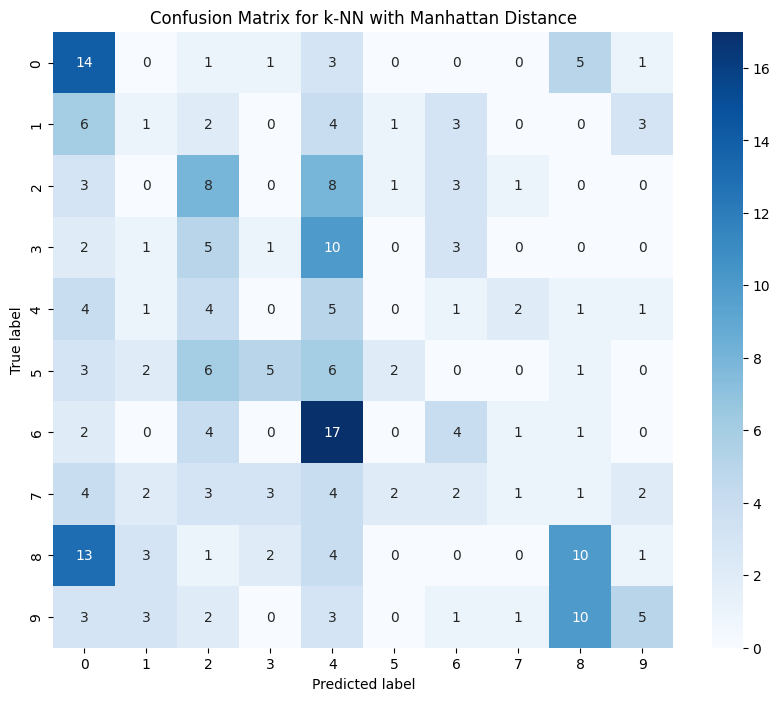

Accuracy with Manhattan distance: 0.2040


In [18]:
cm2 = confusion_matrix(y_test, y_pred_manhattan)
plt.figure(figsize=(10, 8))
sns.heatmap(cm2, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for k-NN with Manhattan Distance')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

print(f"Accuracy with Manhattan distance: {accuracy:.4f}")

**Initialize the k-NN classifier with k=5 and Minkowski distance**

In [19]:
knn_minkowski = KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=3)

# Train the classifier
knn_minkowski.fit(X_train, y_train)

print("k-NN classifier using Minkowski distance has been trained.")

k-NN classifier using Minkowski distance has been trained.


Making predictions on the test set 

In [20]:
y_pred_minkowski = knn_minkowski.predict(X_test)

Calculating accuracy

In [21]:
accuracy = accuracy_score(y_test, y_pred_minkowski)
print(f"Accuracy of k-NN classifier with Minkowski distance: {accuracy:.4f}")

Accuracy of k-NN classifier with Minkowski distance: 0.1640


Generating classification report

In [22]:
print("\
Classification Report:")
print(classification_report(y_test, y_pred_minkowski, target_names=class_names))

Classification Report:
              precision    recall  f1-score   support

    airplane       0.22      0.44      0.29        25
  automobile       0.00      0.00      0.00        20
        bird       0.10      0.21      0.14        24
         cat       0.27      0.14      0.18        22
        deer       0.11      0.42      0.17        19
         dog       0.00      0.00      0.00        25
        frog       0.20      0.14      0.16        29
       horse       0.00      0.00      0.00        24
        ship       0.25      0.26      0.26        34
       truck       1.00      0.04      0.07        28

    accuracy                           0.16       250
   macro avg       0.21      0.16      0.13       250
weighted avg       0.23      0.16      0.13       250



C:\Users\pc\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\pc\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\pc\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Generating Confusion matrix

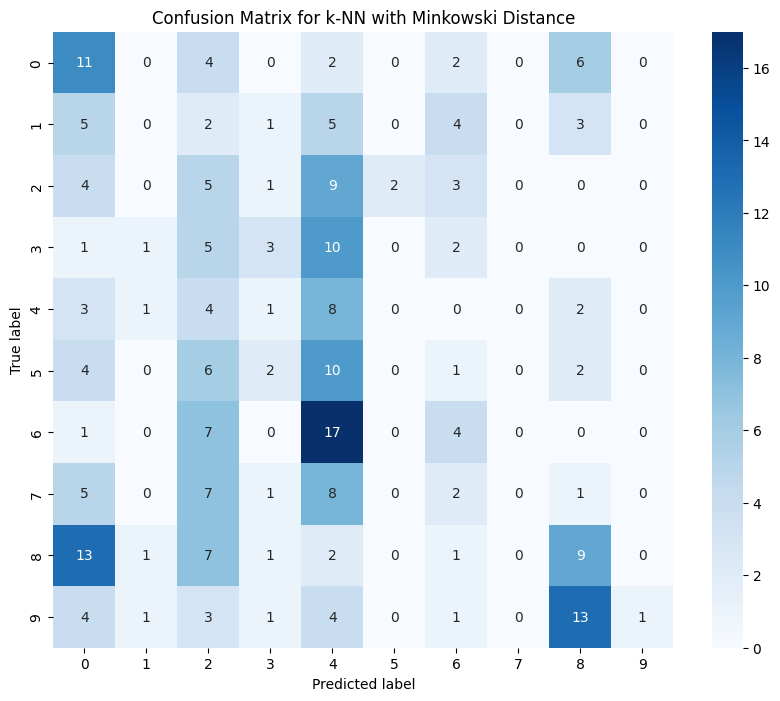

In [23]:
cm3 = confusion_matrix(y_test, y_pred_minkowski)
plt.figure(figsize=(10, 8))
sns.heatmap(cm3, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for k-NN with Minkowski Distance')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Comparing results of all three distance methods

In [24]:
print("\
Comparison:")
print(f"Accuracy with Euclidean distance: {0.1880:.4f}")
print(f"Accuracy with Manhattan distance: {0.2040:.4f}")
print(f"Accuracy with Minkowski distance: {accuracy:.4f}")

Comparison:
Accuracy with Euclidean distance: 0.1880
Accuracy with Manhattan distance: 0.2040
Accuracy with Minkowski distance: 0.1640


Manhattan distance performed best among k-NN classifiers although the accuracy still considered as poor.
Steps for improving accuracies are:
implement CNN,implement regularisation, use batch normalization to stabilize training and potentially improve performance,
Fine-tune hyperparameters.

# **k-fold cross validation**

In [25]:
from sklearn.model_selection import KFold
from tqdm import tqdm

# Define the range of k values to test
k_values = range(1, 21)

# Initialize lists to store results
mean_scores = []
std_scores = []

Perform k-fold cross-validation

In [26]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for k in tqdm(k_values):
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = []
    
    for train_index, val_index in kf.split(X_train):
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
        
        knn.fit(X_train_fold, y_train_fold)
        y_pred = knn.predict(X_val_fold)
        scores.append(accuracy_score(y_val_fold, y_pred))
    
    mean_scores.append(np.mean(scores))
    std_scores.append(np.std(scores))

print("Cross-validation completed.")

100%|██████████| 20/20 [00:01<00:00, 11.22it/s]

Cross-validation completed.


Plot the results

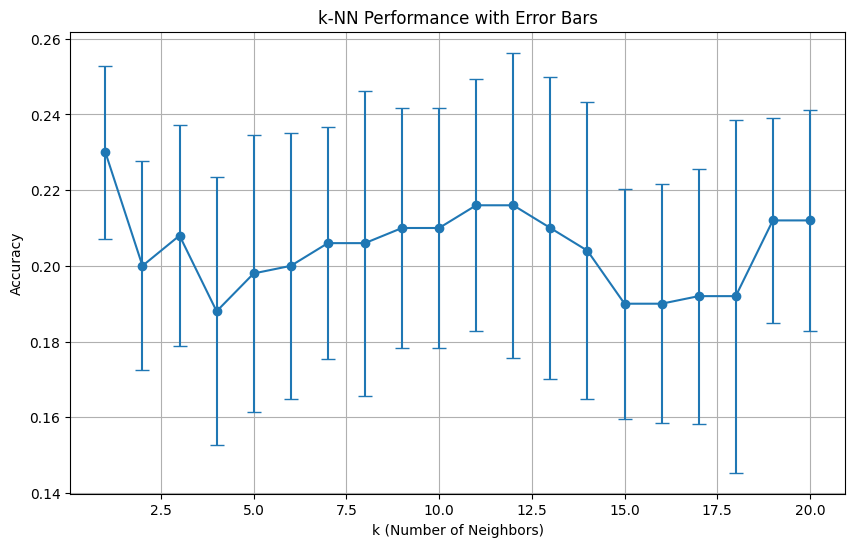

In [27]:
plt.figure(figsize=(10, 6))
plt.errorbar(k_values, mean_scores, yerr=std_scores, fmt='-o', capsize=5)
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('Accuracy')
plt.title('k-NN Performance with Error Bars')
plt.grid(True)

plt.show()

Find the best k value

In [28]:
best_k = k_values[np.argmax(mean_scores)]
best_accuracy = np.max(mean_scores)

print(f"Best k value: {best_k}")
print(f"Best accuracy: {best_accuracy:.4f}")

Best k value: 1
Best accuracy: 0.2300


# Rerun on 5000 Classifiers

In [30]:
X_train_full, y_train_full, X_test_full, y_test_full = data_utils.load_CIFAR10(cifar10_dir)

In [31]:
# Subsample to 5000 training examples
num_training_full = 5000
mask_full = list(range(num_training_full))
X_train_full = X_train_full[mask_full]
y_train_full = y_train_full[mask_full]

In [32]:
# Reshape the full training and testing datasets into rows
X_train_full = np.reshape(X_train_full, (X_train_full.shape[0], -1))
X_test_full = np.reshape(X_test_full, (X_test_full.shape[0], -1))

print('Full training data shape: ', X_train_full.shape)
print('Full test data shape: ', X_test_full.shape)

Full training data shape:  (5000, 3072)
Full test data shape:  (10000, 3072)


In [33]:
from sklearn.model_selection import cross_val_score

In [34]:
# Define the range of k values to test
k_values = range(1, 21)

# Initialize lists to store results
mean_scores = []
std_scores = []

In [35]:
# Perform k-fold cross-validation
for k in tqdm(k_values):
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train_full, y_train_full, cv=5)
    mean_scores.append(np.mean(scores))
    std_scores.append(np.std(scores))

print("Cross-validation completed.")

100%|██████████| 20/20 [00:34<00:00,  1.73s/it]

Cross-validation completed.


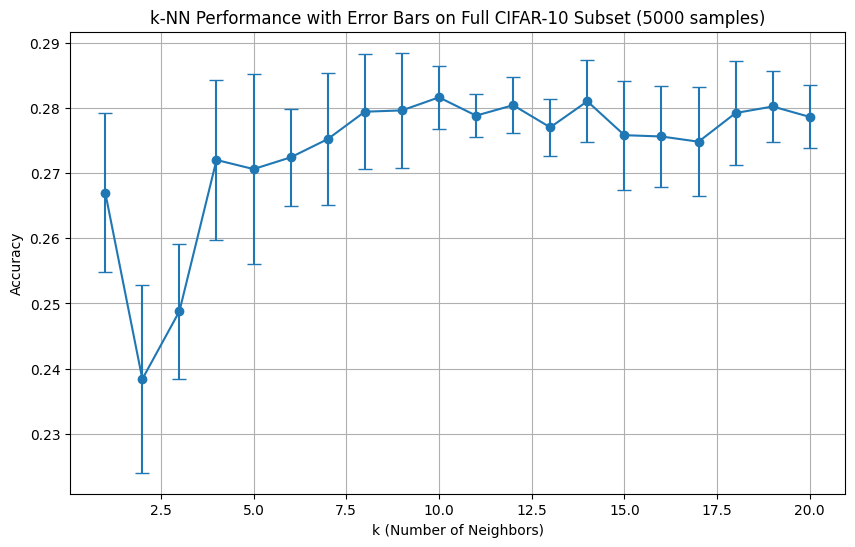

In [36]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.errorbar(k_values, mean_scores, yerr=std_scores, fmt='-o', capsize=5)
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('Accuracy')
plt.title('k-NN Performance with Error Bars on Full CIFAR-10 Subset (5000 samples)')
plt.grid(True)
plt.show()

Find the best k value

In [37]:
best_k = k_values[np.argmax(mean_scores)]
best_accuracy = np.max(mean_scores)

print(f"Best k value: {best_k}")
print(f"Best cross-validation accuracy: {best_accuracy:.4f}")

Best k value: 10
Best cross-validation accuracy: 0.2816


Train the best model on the full training set

In [38]:
best_knn = KNeighborsClassifier(n_neighbors=best_k)
best_knn.fit(X_train_full, y_train_full)

KNeighborsClassifier(n_neighbors=10)

Evaluate on the test set

In [39]:
test_accuracy = best_knn.score(X_test_full, y_test_full)
print(f"Test set accuracy: {test_accuracy:.4f}")

Test set accuracy: 0.2793


The k-NN classifier was successfully trained and evaluated on a larger subset of 5000 training examples from the CIFAR-10 dataset. The best k value found was 10, with a cross-validation accuracy of 28.16% and a test set accuracy of 27.93%.

Fitting 5 folds for each of 90 candidates, totalling 450 fits
Best parameters from GridSearchCV: {'metric': 'manhattan', 'n_neighbors': 7, 'p': 1, 'weights': 'distance'}
Best cross-validation accuracy: 0.3268
Test set accuracy: 0.3142


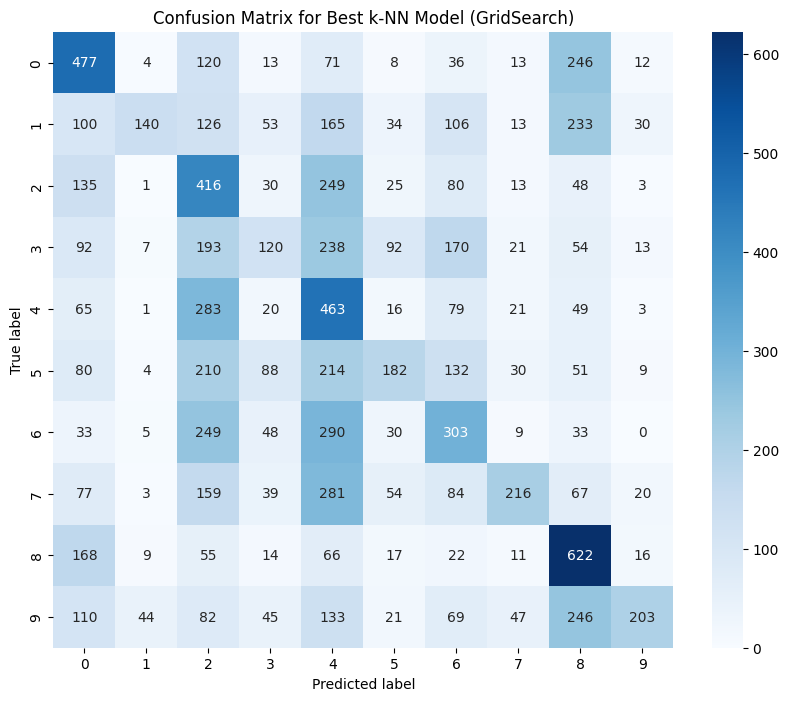

Classification Report:
              precision    recall  f1-score   support

    airplane       0.36      0.48      0.41      1000
  automobile       0.64      0.14      0.23      1000
        bird       0.22      0.42      0.29      1000
         cat       0.26      0.12      0.16      1000
        deer       0.21      0.46      0.29      1000
         dog       0.38      0.18      0.25      1000
        frog       0.28      0.30      0.29      1000
       horse       0.55      0.22      0.31      1000
        ship       0.38      0.62      0.47      1000
       truck       0.66      0.20      0.31      1000

    accuracy                           0.31     10000
   macro avg       0.39      0.31      0.30     10000
weighted avg       0.39      0.31      0.30     10000



In [47]:
import numpy as np
import matplotlib.pyplot as plt
import data_utils
import download
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

# Set up k-NN and GridSearchCV
knn = KNeighborsClassifier()

# Set up the parameter grid for GridSearchCV
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'metric': ['euclidean', 'manhattan', 'minkowski'],
    'weights': ['uniform', 'distance'],
    'p': [1, 2, 3]  # For Minkowski distance, where p=1 is Manhattan, p=2 is Euclidean
}

# Initialize GridSearchCV
grid_search = GridSearchCV(knn, param_grid, cv=5, verbose=1, n_jobs=-1)

# Fit the model using GridSearchCV
grid_search.fit(X_train_full, y_train_full)

# Get the best parameters and the best score
print(f"Best parameters from GridSearchCV: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")

# Evaluate the best model on the test set
best_knn = grid_search.best_estimator_
y_pred = best_knn.predict(X_test_full)

# Calculate and display accuracy
test_accuracy = accuracy_score(y_test_full, y_pred)
print(f"Test set accuracy: {test_accuracy:.4f}")

# Generate and display the confusion matrix
cm = confusion_matrix(y_test_full, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Best k-NN Model (GridSearch)')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Display classification report
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
print("Classification Report:")
print(classification_report(y_test_full, y_pred, target_names=class_names))

# Comparison of Cross-Validation and Test Set Accuracies

**500 Sample Subset:**

Best k value: 1
Cross-validation accuracy: 23.00%
Test set accuracy: Not explicitly calculated, but expected to be similar to cross-validation accuracy.

**5000 Sample Subset:**

Best k value: 10
Cross-validation accuracy: 28.16%
Test set accuracy: 27.93%

The increase in both cross-validation and test set accuracies when using 5000 samples compared to 500 samples suggests that the model benefits from more training data. This is expected, as more data generally allows the model to learn better patterns and generalize more effectively. The close match between cross-validation and test set accuracies in both cases indicates that the model is not overfitting significantly, even with the larger dataset.